# Visualising results from benchmarking the different methods, on both the full tabula sapiens dataset, as well as the smaller subset.
                                     
## INPUT: 

    * data/test_data/TabulaSapiens.h5ad
    * data/test_data/TabulaSapiens_subset.h5ad
    * data/test_data/TabulaSapiens_tiny.h5ad
    * data/test_data/giotto_tabula_results.pkl
    * data/test_data/code_tabula_results.pkl
    * data/test_data/code_tabula-full_results.pkl
    * data/test_data/coexpr_tabula_results.pkl
    * data/test_data/coexpr_tabula-full_results.pkl
    * data/test_data/scanpy_tabula_results.pkl
    * data/test_data/scanpy_tabula-full_results.pkl
    * data/test_data/Tabula-small_scHC-clusts_counts.pkl
    
## OUTPUT: 

    * None, plots within
    
# Environment Setup

In [1]:
work_dir = './' #put path to Cytocipher_manuscript/
import os
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

import seaborn as sb
from matplotlib_venn import venn2

pre_dir = '/media/WorkingSpace/Share/hypo_atlas/'
data_dir = pre_dir+'data/test_data/'
out_dir = data_dir

import cytocipher as cc
import importlib as imp

import utils.preprocessing.load_data.simple_pickle as spl

## Loading the data

In [2]:
data = sc.read_h5ad(data_dir+'TabulaSapiens_subset.h5ad')

In [3]:
data.shape

(7385, 2435)

In [4]:
data.layers.keys() # Doesn't have counts! Will need to add...

KeysView(Layers with keys: counts)

In [5]:
#### Loading each of the results...
methods = ['code', 'coexpr', 'giotto', 'scanpy']
method_results = {}
for method in methods:
    method_results[method] = spl.loadPickle(data_dir+f'{method}_tabula_results.pkl')

In [10]:
method_results['scanpy'].keys()

dict_keys(['enrich', 'overclusters_scanpy_scores', 'overclusters_merged_scanpy_scores', 'overclusters_scanpy_merged', 'overclusters_markers_scanpy', 'overclusters_merged_markers_scanpy', 'overclusters_mutualpairs_scanpy', 'overclusters_neighbours_scanpy', 'overclusters_neighdists_scanpy', 'overclusters_padjs_scanpy', 'overclusters_ps_scanpy'])

In [ ]:
#### Checking access of the p-values...
method_results['scanpy']['overclusters_ps_scanpy']

## Benchmarking with ROC curve AUC

In [12]:
##### Let's get true versus false pairs based on pairs which belong to same higher cluster...
groupby = 'overclusters'
pairs = np.array(list(data.uns[f'{groupby}_ps'].keys()))
pair_labels = []
pair_new_label = []

# Ground truth labels; clusters which mutually fall within one of these clusters should not be different.
ground_truth = data.obs['cell_ontology_class'].values.astype(str)
ground_truth_set = np.unique( ground_truth )
for pair in pairs:
    pair1 = [label for label in ground_truth_set if pair.split('_')[0]==label][0]
    pair1 = pair1+'_'+pair.split(pair1)[1].split('_')[1]
    pair2 = pair.split(pair1)[1].strip('_')
    #print(pair)
    #print(pair1, '---', pair2, '\n')
    truth1 = pair1.split('_')[0]
    truth2 = pair2.split('_')[0]
    
    if truth1 == truth2:
        pair_labels.append( 1 )
        pair_new_label.append( truth1 )
    else:
        pair_labels.append( 0 )
        pair_new_label.append('other')

pair_new_label = np.array(pair_new_label)
pair_labels = np.array( pair_labels )

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#method_colors = {'code': 'gold', 'coexpr': 'deepskyblue', 'giotto': 'violet', 'scanpy': 'gold'}

method_colors = {'code': 'cyan', 'coexpr': 'dodgerblue', 'giotto': 'magenta', 'scanpy': 'gold'}

##### Logging to try and get a better range...
res = 200
p_cuts = np.array([2**(-i) for i in range(res)]+[0])[::-1]
p_cuts = p_cuts
p_cuts

array([0.00000000e+00, 1.24460306e-60, 2.48920611e-60, 4.97841222e-60,
       9.95682444e-60, 1.99136489e-59, 3.98272978e-59, 7.96545956e-59,
       1.59309191e-58, 3.18618382e-58, 6.37236764e-58, 1.27447353e-57,
       2.54894706e-57, 5.09789412e-57, 1.01957882e-56, 2.03915765e-56,
       4.07831529e-56, 8.15663058e-56, 1.63132612e-55, 3.26265223e-55,
       6.52530447e-55, 1.30506089e-54, 2.61012179e-54, 5.22024357e-54,
       1.04404871e-53, 2.08809743e-53, 4.17619486e-53, 8.35238972e-53,
       1.67047794e-52, 3.34095589e-52, 6.68191178e-52, 1.33638236e-51,
       2.67276471e-51, 5.34552942e-51, 1.06910588e-50, 2.13821177e-50,
       4.27642354e-50, 8.55284707e-50, 1.71056941e-49, 3.42113883e-49,
       6.84227766e-49, 1.36845553e-48, 2.73691106e-48, 5.47382213e-48,
       1.09476443e-47, 2.18952885e-47, 4.37905770e-47, 8.75811540e-47,
       1.75162308e-46, 3.50324616e-46, 7.00649232e-46, 1.40129846e-45,
       2.80259693e-45, 5.60519386e-45, 1.12103877e-44, 2.24207754e-44,
      

In [14]:
from statsmodels.stats.multitest import multipletests

##### Which method gets ground-truth best???
method_labels = []
adjust = False

method_fprs = {}
method_tprs = {}
method_aucs = {}

for j, method in enumerate(methods):

    # Get p-values
    pvals = np.array([method_results[method][f'overclusters_ps_{method}'][pair]
                      for pair in pairs])
    # Randomising order just to make sure random is RANDOM!
    #pvals = np.random.choice(pvals, size=len(pvals), replace=False)
    if adjust:
        pvals = multipletests(pvals, method='fdr_bh')[1]
  
    # Compute ROC curve and ROC area for each class
    n_nonsig, n_sig = sum(pair_labels==1), sum(pair_labels==0)
    fpr, tpr = np.zeros((len(p_cuts))), np.zeros((len(p_cuts)))
    for pi, p_cut_ in enumerate(p_cuts):
        nonsig_bool = pvals >= p_cut_
        
        tp = sum(np.logical_and(nonsig_bool, pair_labels==1))
        tpr[pi] = tp / n_nonsig
        
        fp = sum(np.logical_and(nonsig_bool, pair_labels==0))
        #print(p_cut, fp)
        fpr[pi] = fp / n_sig
    
    #print(thresholds)
    roc_auc = auc(fpr, tpr)
    
    method_fprs[method] = fpr
    method_tprs[method] = tpr
    method_aucs[method] = roc_auc
    
    print(method, roc_auc)

code 0.9929562396026081
coexpr 0.9936948418302102
giotto 0.994522293647159
scanpy 0.8786217554462543


In [16]:
out_plots

'plots/coexpr_score/revision/sapiens/'

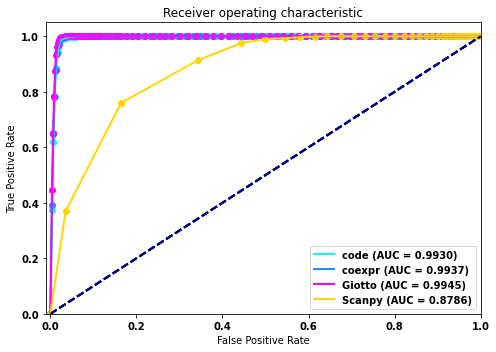

In [21]:
methods_ = ['code', 'coexpr', 'giotto', 'scanpy']
method_names = ['code', 'coexpr', 'Giotto', 'Scanpy']
plt.figure(figsize=(7,5))
for j, method in enumerate(methods):
    fpr = method_fprs[method]
    tpr = method_tprs[method]
    roc_auc = method_aucs[method]

    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=method_colors[method],
        lw=lw,
        label=f"{method_names[j]} (AUC = %0.4f)" % roc_auc,
    )
    plt.scatter(fpr, tpr, color=method_colors[method],)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
plt.show()

### Now also regenerating for the negative Giotto and Scanpy cases

In [22]:
method_results[method].keys()

dict_keys(['enrich', 'overclusters_scanpy_scores', 'overclusters_merged_scanpy_scores', 'overclusters_scanpy_merged', 'overclusters_markers_scanpy', 'overclusters_merged_markers_scanpy', 'overclusters_mutualpairs_scanpy', 'overclusters_neighbours_scanpy', 'overclusters_neighdists_scanpy', 'overclusters_padjs_scanpy', 'overclusters_ps_scanpy'])

In [24]:
code_scores = method_results['code']['overclusters_code_scores']
coexpr_scores = method_results['coexpr']['overclusters_coexpr_scores']

negative_set_cells = np.logical_and(code_scores==0, coexpr_scores>0)

giotto_neg_scores = method_results['giotto']['overclusters_giotto_scores'].copy()
scanpy_neg_scores = method_results['scanpy']['overclusters_scanpy_scores'].copy()

giotto_neg_scores[negative_set_cells] = 0
scanpy_neg_scores[negative_set_cells] = 0

cluster_key = 'overclusters'
data.obsm[f'giotto-neg_{cluster_key}_enrich_scores'] = giotto_neg_scores
data.obsm[f'scanpy-neg_{cluster_key}_enrich_scores'] = scanpy_neg_scores

In [26]:
####### Getting the p-values
k=15
mnn_frac_cutoff=None
random_state=20
p_cut=0.01
score_group_method='quantiles'
p_adjust=True
p_adjust_method='fdr_bh'

In [28]:
import cytocipher.score_and_merge.cluster_merge as cm
imp.reload(cm)

for method in ['giotto-neg', 'scanpy-neg']:
    
    method_results[method] = {}
    
    data.obsm[f'{cluster_key}_enrich_scores'] = data.obsm[f'{method}_{cluster_key}_enrich_scores']
    cm.merge_clusters_single(data, cluster_key, f'{cluster_key}_merged',
                            k=k, mnn_frac_cutoff=mnn_frac_cutoff, random_state=random_state,
                          p_cut=p_cut,
                          score_group_method=score_group_method,
                          p_adjust=p_adjust, p_adjust_method=p_adjust_method,
                          verbose=False)
    
    method_results[method][f'overclusters_ps_{method}'] = data.uns[f'{cluster_key}_ps']
    method_results[method][f'overclusters_{method}_scores'] = data.obsm[f'{method}_{cluster_key}_enrich_scores']

In [30]:
method_results.keys()

dict_keys(['code', 'coexpr', 'giotto', 'scanpy', 'giotto-neg', 'scanpy-neg'])

In [33]:
#### Saving so don't need to regenerate....
spl.saveAsPickle(data_dir+f'tabula_results_compiled.pkl', method_results)

### Generating ROC Curves

In [35]:
methods = ['code', 'coexpr', 'giotto', 'giotto-neg', 'scanpy', 'scanpy-neg']
method_colors = {'code': 'cyan', 'coexpr': 'dodgerblue',
                'giotto': 'magenta', 'giotto-neg': 'orchid', 
                 'scanpy': 'gold', 'scanpy-neg': 'goldenrod'}

In [36]:
from statsmodels.stats.multitest import multipletests

##### Which method gets ground-truth best???
method_labels = []
adjust = False

method_fprs = {}
method_tprs = {}
method_aucs = {}

for j, method in enumerate(methods):

    # Get p-values
    pvals = np.array([method_results[method][f'overclusters_ps_{method}'][pair]
                      for pair in pairs])
    # Randomising order just to make sure random is RANDOM!
    #pvals = np.random.choice(pvals, size=len(pvals), replace=False)
    if adjust:
        pvals = multipletests(pvals, method='fdr_bh')[1]
  
    # Compute ROC curve and ROC area for each class
    n_nonsig, n_sig = sum(pair_labels==1), sum(pair_labels==0)
    fpr, tpr = np.zeros((len(p_cuts))), np.zeros((len(p_cuts)))
    for pi, p_cut_ in enumerate(p_cuts):
        nonsig_bool = pvals >= p_cut_
        
        tp = sum(np.logical_and(nonsig_bool, pair_labels==1))
        tpr[pi] = tp / n_nonsig
        
        fp = sum(np.logical_and(nonsig_bool, pair_labels==0))
        #print(p_cut, fp)
        fpr[pi] = fp / n_sig
    
    #print(thresholds)
    roc_auc = auc(fpr, tpr)
    
    method_fprs[method] = fpr
    method_tprs[method] = tpr
    method_aucs[method] = roc_auc
    
    print(method, roc_auc)

code 0.9929562396026081
coexpr 0.9936948418302102
giotto 0.994522293647159
giotto-neg 0.9939601039835121
scanpy 0.8786217554462543
scanpy-neg 0.8902197783507122


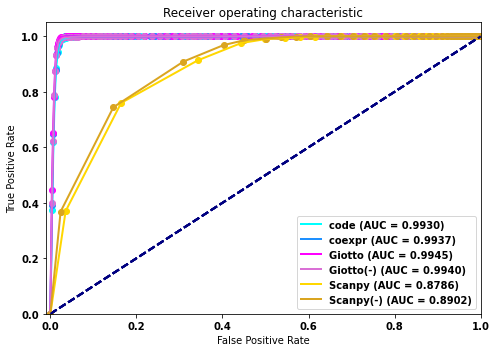

In [37]:
methods_ = ['code', 'coexpr', 'giotto', 'giotto-neg', 'scanpy', 'scanpy-neg']
method_names = ['code', 'coexpr', 'Giotto', 'Giotto(-)', 'Scanpy', 'Scanpy(-)']
plt.figure(figsize=(7,5))
for j, method in enumerate(methods):
    fpr = method_fprs[method]
    tpr = method_tprs[method]
    roc_auc = method_aucs[method]

    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=method_colors[method],
        lw=lw,
        label=f"{method_names[j]} (AUC = %0.4f)" % roc_auc,
    )
    plt.scatter(fpr, tpr, color=method_colors[method],)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
plt.show()

# Now also making for the full dataset

In [9]:
data = sc.read_h5ad(data_dir+'TabulaSapiens_Cytociphered.h5ad')

In [10]:
data.shape

(483152, 58870)

In [11]:
#### Loading each of the results...
methods = ['code', 'coexpr', 'scanpy']
method_results = {}
for method in methods:
    method_results[method] = spl.loadPickle(data_dir+f'{method}_tabula-full_results.pkl')

In [12]:
##### Let's get true versus false pairs based on pairs which belong to same higher cluster...
groupby = 'overclusters'
pairs = np.array(list(data.uns[f'{groupby}_ps'].keys()))
pair_labels = []
pair_new_label = []

# Ground truth labels; clusters which mutually fall within one of these clusters should not be different.
ground_truth = data.obs['cell_ontology_class'].values.astype(str)
ground_truth_set = np.unique( ground_truth )
for pair in pairs:
    pair1 = [label for label in ground_truth_set if pair.split('_')[0]==label][0]
    pair1 = pair1+'_'+pair.split(pair1)[1].split('_')[1]
    pair2 = pair.split(pair1)[1].strip('_')
    #print(pair)
    #print(pair1, '---', pair2, '\n')
    truth1 = pair1.split('_')[0]
    truth2 = pair2.split('_')[0]
    
    if truth1 == truth2:
        pair_labels.append( 1 )
        pair_new_label.append( truth1 )
    else:
        pair_labels.append( 0 )
        pair_new_label.append('other')

pair_new_label = np.array(pair_new_label)
pair_labels = np.array( pair_labels )

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

method_colors = {'code': 'cyan', 'coexpr': 'dodgerblue', 
                 'giotto': 'magenta', 'giotto-neg': 'orchid', 
                 'scanpy': 'gold', 'scanpy-neg': 'goldenrod'}

##### Logging to try and get a better range...
res = 200
p_cuts = np.array([2**(-i) for i in range(res)]+[0])[::-1]
p_cuts = p_cuts
p_cuts

array([0.00000000e+00, 1.24460306e-60, 2.48920611e-60, 4.97841222e-60,
       9.95682444e-60, 1.99136489e-59, 3.98272978e-59, 7.96545956e-59,
       1.59309191e-58, 3.18618382e-58, 6.37236764e-58, 1.27447353e-57,
       2.54894706e-57, 5.09789412e-57, 1.01957882e-56, 2.03915765e-56,
       4.07831529e-56, 8.15663058e-56, 1.63132612e-55, 3.26265223e-55,
       6.52530447e-55, 1.30506089e-54, 2.61012179e-54, 5.22024357e-54,
       1.04404871e-53, 2.08809743e-53, 4.17619486e-53, 8.35238972e-53,
       1.67047794e-52, 3.34095589e-52, 6.68191178e-52, 1.33638236e-51,
       2.67276471e-51, 5.34552942e-51, 1.06910588e-50, 2.13821177e-50,
       4.27642354e-50, 8.55284707e-50, 1.71056941e-49, 3.42113883e-49,
       6.84227766e-49, 1.36845553e-48, 2.73691106e-48, 5.47382213e-48,
       1.09476443e-47, 2.18952885e-47, 4.37905770e-47, 8.75811540e-47,
       1.75162308e-46, 3.50324616e-46, 7.00649232e-46, 1.40129846e-45,
       2.80259693e-45, 5.60519386e-45, 1.12103877e-44, 2.24207754e-44,
      

In [43]:
from statsmodels.stats.multitest import multipletests

##### Which method gets ground-truth best???
method_labels = []
adjust = False

method_fprs = {}
method_tprs = {}
method_aucs = {}

for j, method in enumerate(methods):

    # Get p-values
    pvals = np.array([method_results[method][f'overclusters_ps_{method}'][pair]
                      for pair in pairs])
    if adjust:
        pvals = multipletests(pvals, method='fdr_bh')[1]
  
    # Compute ROC curve and ROC area for each class
    n_nonsig, n_sig = sum(pair_labels==1), sum(pair_labels==0)
    fpr, tpr = np.zeros((len(p_cuts))), np.zeros((len(p_cuts)))
    for pi, p_cut_ in enumerate(p_cuts):
        nonsig_bool = pvals >= p_cut_
        
        tp = sum(np.logical_and(nonsig_bool, pair_labels==1))
        tpr[pi] = tp / n_nonsig
        
        fp = sum(np.logical_and(nonsig_bool, pair_labels==0))
        #print(p_cut, fp)
        fpr[pi] = fp / n_sig
    
    #print(thresholds)
    roc_auc = auc(fpr, tpr)
    
    method_fprs[method] = fpr
    method_tprs[method] = tpr
    method_aucs[method] = roc_auc
    
    print(method, roc_auc)

code 0.9974413379290805
coexpr 0.9976139048767878
scanpy 0.8852366584921711


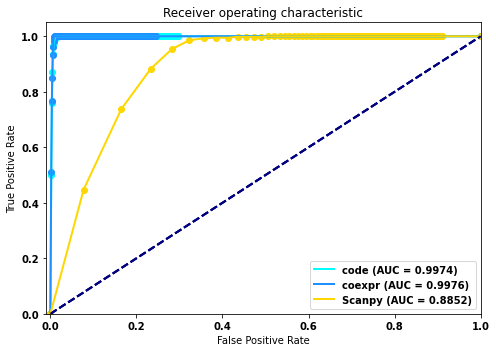

In [44]:
methods_ = ['code', 'coexpr', 'scanpy']
method_names = ['code', 'coexpr', 'Scanpy']
plt.figure(figsize=(7,5))
for j, method in enumerate(methods):
    fpr = method_fprs[method]
    tpr = method_tprs[method]
    roc_auc = method_aucs[method]

    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=method_colors[method],
        lw=lw,
        label=f"{method_names[j]} (AUC = %0.4f)" % roc_auc,
    )
    plt.scatter(fpr, tpr, color=method_colors[method],)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
plt.show()

### Now also regenerating for the negative Scanpy cases

In [47]:
code_scores = method_results['code']['overclusters_code_scores']
coexpr_scores = method_results['coexpr']['overclusters_coexpr_scores']

negative_set_cells = np.logical_and(code_scores==0, coexpr_scores>0)

scanpy_neg_scores = method_results['scanpy']['overclusters_scanpy_scores'].copy()

scanpy_neg_scores[negative_set_cells] = 0

cluster_key = 'overclusters'
data.obsm[f'scanpy-neg_{cluster_key}_enrich_scores'] = scanpy_neg_scores

In [48]:
####### Getting the p-values
k=15
mnn_frac_cutoff=None
random_state=20
p_cut=0.01
score_group_method='quantiles'
p_adjust=True
p_adjust_method='fdr_bh'

In [49]:
import cytocipher.score_and_merge.cluster_merge as cm
imp.reload(cm)

for method in ['scanpy-neg']:
    
    method_results[method] = {}
    
    data.obsm[f'{cluster_key}_enrich_scores'] = data.obsm[f'{method}_{cluster_key}_enrich_scores']
    cm.merge_clusters_single(data, cluster_key, f'{cluster_key}_merged',
                            k=k, mnn_frac_cutoff=mnn_frac_cutoff, random_state=random_state,
                          p_cut=p_cut,
                          score_group_method=score_group_method,
                          p_adjust=p_adjust, p_adjust_method=p_adjust_method,
                          verbose=False)
    
    method_results[method][f'overclusters_ps_{method}'] = data.uns[f'{cluster_key}_ps']
    method_results[method][f'overclusters_{method}_scores'] = data.obsm[f'{method}_{cluster_key}_enrich_scores']

In [50]:
method_results.keys()

dict_keys(['code', 'coexpr', 'scanpy', 'scanpy-neg'])

In [51]:
#### Saving so don't need to regenerate....
spl.saveAsPickle(data_dir+f'tabula-full_results_compiled.pkl', method_results)

### Now generating ROC

In [14]:
method_results = spl.loadPickle(data_dir+f'tabula-full_results_compiled.pkl')

In [15]:
methods = ['code', 'coexpr', 'scanpy', 'scanpy-neg']
method_colors = {'code': 'cyan', 'coexpr': 'dodgerblue',
                'giotto': 'magenta', 'giotto-neg': 'orchid', 
                 'scanpy': 'gold', 'scanpy-neg': 'goldenrod'}

In [16]:
from statsmodels.stats.multitest import multipletests

##### Which method gets ground-truth best???
method_labels = []
adjust = False

method_fprs = {}
method_tprs = {}
method_aucs = {}

for j, method in enumerate(methods):

    # Get p-values
    pvals = np.array([method_results[method][f'overclusters_ps_{method}'][pair]
                      for pair in pairs])
    # Randomising order just to make sure random is RANDOM!
    #pvals = np.random.choice(pvals, size=len(pvals), replace=False)
    if adjust:
        pvals = multipletests(pvals, method='fdr_bh')[1]
  
    # Compute ROC curve and ROC area for each class
    n_nonsig, n_sig = sum(pair_labels==1), sum(pair_labels==0)
    fpr, tpr = np.zeros((len(p_cuts))), np.zeros((len(p_cuts)))
    for pi, p_cut_ in enumerate(p_cuts):
        nonsig_bool = pvals >= p_cut_
        
        tp = sum(np.logical_and(nonsig_bool, pair_labels==1))
        tpr[pi] = tp / n_nonsig
        
        fp = sum(np.logical_and(nonsig_bool, pair_labels==0))
        #print(p_cut, fp)
        fpr[pi] = fp / n_sig
    
    #print(thresholds)
    roc_auc = auc(fpr, tpr)
    
    method_fprs[method] = fpr
    method_tprs[method] = tpr
    method_aucs[method] = roc_auc
    
    print(method, roc_auc)

code 0.9974413379290805
coexpr 0.9976139048767878
scanpy 0.8852366584921711
scanpy-neg 0.8923795735922166


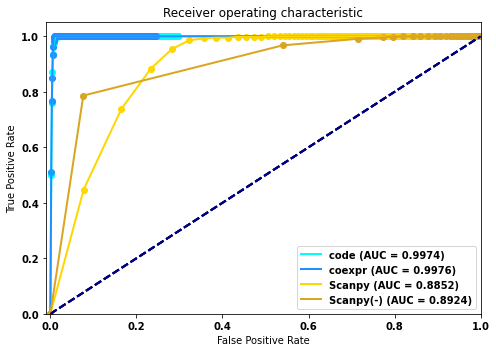

In [17]:
methods_ = ['code', 'coexpr', 'scanpy', 'scanpy-neg']
method_names = ['code', 'coexpr', 'Scanpy', 'Scanpy(-)']
plt.figure(figsize=(7,5))
for j, method in enumerate(methods):
    fpr = method_fprs[method]
    tpr = method_tprs[method]
    roc_auc = method_aucs[method]

    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=method_colors[method],
        lw=lw,
        label=f"{method_names[j]} (AUC = %0.4f)" % roc_auc,
    )
    plt.scatter(fpr, tpr, color=method_colors[method],)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
plt.show()

## Now making a plot to represent the Time & Memory usage

In [19]:
#### This was only saved for the full datasets, not the subsets. 
#### For the subsets, the times are displayed in the notebooks.
bench_data = list(open(f'{data_dir}tabula-sub_code-mem.txt', 'r'))
ram = np.array(bench_data[0].strip('\n').strip('(').strip(')').split(',')).astype(int)
ram_peak_gb = (ram[-1]-ram[0])/1e9

time_hrs = float(bench_data[1].strip('\n').split(' ')[-1])/60/60
time_hrs

0.12761020402113596

In [52]:
?qpl.bar_plot

In [97]:
methods

['code', 'coexpr', 'scanpy', 'giotto']

[11.324081   14.22854172 52.22220897  7.11322181]


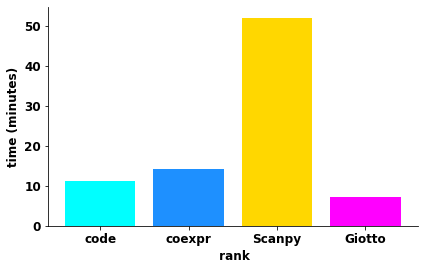

In [99]:
method_names = ['code', 'coexpr', 'Scanpy', 'Giotto']
times_dict = {'code': 679.44486, 'coexpr': 853.712503, 
              'giotto': 426.7933084964752, 'scanpy': 3133.332538127899}
times = np.array([times_dict[method] for method in methods])/60
print(times)

fig, ax = plt.subplots()
qpl.bar_plot(np.array(methods), np.array(methods), times, 
             colors=np.array([method_colors[method] for method in methods]),
             fig=fig, ax=ax, show=False, label_size=0, rank=False, tick_size=12)
ax.set_ylabel('time (minutes)')
ax.set_xticks(list(range(len(method_names))))
ax.set_xticklabels(method_names)
plt.show()

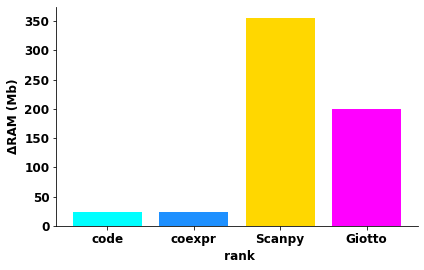

In [100]:
times_dict = {'code': 23.7, 'coexpr': 23.39, 'giotto': 200, 'scanpy': 355.910487}
times = np.array([times_dict[method] for method in methods])

fig, ax = plt.subplots()
qpl.bar_plot(np.array(methods), np.array(methods), times, 
             colors=np.array([method_colors[method] for method in methods]),
             fig=fig, ax=ax, show=False, label_size=0, rank=False, tick_size=12)
ax.set_ylabel('ΔRAM (Mb)')
ax.set_xticks(list(range(len(method_names))))
ax.set_xticklabels(method_names)
plt.show()

In [101]:
imp.reload(qpl)

<module 'beautifulcells.visualisation.quick_plots' from '/home/s4392586/myPython/BeautifulCells/beautifulcells/visualisation/quick_plots.py'>

## Now making a plot to represent the Time & Memory usage for FULL data

In [86]:
#### This was only saved for the full datasets, not the subsets. 
#### For the subsets, the times are displayed in the notebooks.
times_dict = {}
ram_dict = {}
for method in ['code', 'coexpr', 'scanpy']:
    file_ = f'{data_dir}tabula_{method}-mem.txt'
    if method=='scanpy':
        file_ = file_.replace('-mem', '-full-mem')
    bench_data = list(open(file_, 'r'))
    ram = np.array(bench_data[0].strip('\n').strip('(').strip(')').split(',')).astype(int)
    ram_peak_gb = (ram[-1]-ram[0])/1e9
    ram_dict[method] = ram_peak_gb

    time_hrs = float(bench_data[1].strip('\n').split(' ')[-1])/60/60
    times_dict[method] = time_hrs
    
print(times_dict)
print(ram_dict)

{'code': 8.527786302765211, 'coexpr': 15.074521127608087, 'scanpy': 3.7952707846959433}
{'code': 12.208408721, 'coexpr': 1.188436542, 'scanpy': 11.429396434}


In [87]:
methods = ['code', 'coexpr', 'scanpy', 'giotto']
method_names = ['code', 'coexpr', 'Scanpy', 'Giotto']

In [88]:
times

array([0.04974527, 0.04877671, 0.05439626, 0.11599587, 2.98      ])

In [89]:
methods

['code', 'coexpr', 'scanpy', 'giotto']

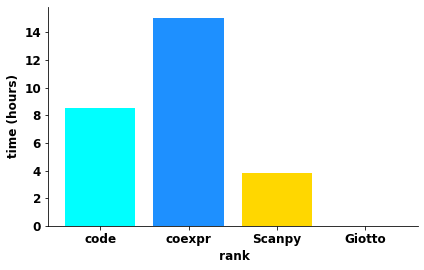

In [49]:
times = np.array(list(times_dict.values())+[0])

fig, ax = plt.subplots()
qpl.bar_plot(np.array(methods), np.array(methods), times, 
             colors=np.array([method_colors[method] for method in methods]),
             fig=fig, ax=ax, show=False, label_size=0, rank=False, tick_size=12)
ax.set_ylabel('time (hours)')
ax.set_xticks(list(range(len(times))))
ax.set_xticklabels(method_names)
plt.show()

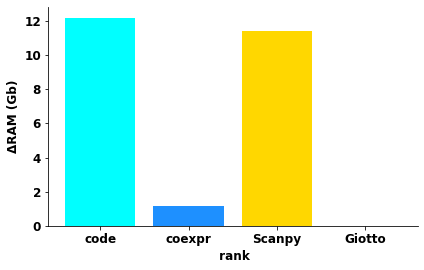

In [90]:
rams = np.array(list(ram_dict.values())+[0])

fig, ax = plt.subplots()
qpl.bar_plot(np.array(methods), np.array(methods), rams, 
             colors=np.array([method_colors[method] for method in methods]),
             fig=fig, ax=ax, show=False, label_size=0, rank=False, tick_size=12)
ax.set_ylabel('ΔRAM (Gb)')
ax.set_xticks(list(range(len(rams))))
ax.set_xticklabels(method_names)
plt.show()

## Now also benchmarking against sc-HCT

In [52]:
tiny = sc.read_h5ad(data_dir+'TabulaSapiens_tiny.h5ad')
tiny.shape

(500, 2180)

In [59]:
import cytocipher.score_and_merge.cluster_merge as cm

def scanpy_merge(data, cluster_key, marker_key,
                 k=15, mnn_frac_cutoff=None, random_state=20, p_cut=0.01, score_group_method='quantiles',
                 p_adjust=True, p_adjust_method='fdr_bh'):
    
    ### Scanpy-scoring.
    scanpy_scores = np.zeros((data.shape[0], len(data.uns[marker_key])))
    for i, group in enumerate(data.uns[marker_key]):
        sc.tl.score_genes(data, data.uns[marker_key][group])
        scanpy_scores[:,i] = data.obs['score'].values
    scanpy_scores = pd.DataFrame(scanpy_scores, index=data.obs_names, columns = list(data.uns[marker_key].keys()))
    data.obsm[f'{cluster_key}_enrich_scores'] = scanpy_scores
    
    ### Merging by Scanpy-score.
    cm.merge_clusters_single(data, cluster_key, f'{cluster_key}_merged',
                            k=k, mnn_frac_cutoff=mnn_frac_cutoff, random_state=random_state,
                          p_cut=p_cut,
                          score_group_method=score_group_method,
                          p_adjust=p_adjust, p_adjust_method=p_adjust_method,
                          verbose=False)

In [60]:
methods

['code', 'coexpr', 'scanpy', 'giotto']

In [106]:
import time
import tracemalloc

times_dict = {}
ram_dict = {}
for method in methods:
    
    if method!='scanpy':
        start = time.time()
        tracemalloc.start()
        cc.tl.merge_clusters(tiny, 'overclusters', n_cpus=15, max_iter=0, 
                             enrich_method=method, 
                              k=None, squash_exception=True,
                             )
        tiny.obs[f'overclusters_{method}_merged'] = tiny.obs['overclusters_merged']
        mem_start, mem_end = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        end = time.time()
    else:
        start = time.time()
        tracemalloc.start()
        
        #### Need to re-determine the marker genes, so timing is consistent between approaches
        # The inputted values are the same as the default values when runnin cc.tl.merge_clusters above.
        cc.tl.get_markers(tiny, 'overclusters', n_top=6, verbose=False,
                var_groups=None, t_cutoff=3,
                padj_cutoff=0.05,
                gene_order=None, min_de=0)
        
        scanpy_merge(tiny, 'overclusters', 'overclusters_markers',
                 k=None, mnn_frac_cutoff=None, random_state=20, p_cut=0.01,
                 p_adjust=True, p_adjust_method='fdr_bh')
        
        tiny.obs[f'overclusters_{method}_merged'] = tiny.obs['overclusters_merged']
        mem_start, mem_end = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        end = time.time()
        
    tiny.obsm[f'{method}_overclusters_enrich_scores'] = tiny.obsm[f'overclusters_enrich_scores']
    
    times_dict[method] = (end-start)/60
    ram_dict[method] = (mem_end-mem_start) / 1e6
    
print(times_dict)
print(ram_dict)

Initial merge.


/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Added data.obs[f'overclusters_merged']
Exiting due to reaching max_iter 0
Initial merge.


/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Added data.obs[f'overclusters_merged']
Exiting due to reaching max_iter 0


/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use 

Initial merge.


/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Added data.obs[f'overclusters_merged']
Exiting due to reaching max_iter 0
{'code': 0.049800463517506915, 'coexpr': 0.04986850023269653, 'scanpy': 0.059065508842468264, 'giotto': 0.030532185236612955}
{'code': 11.198944, 'coexpr': 8.760429, 'scanpy': 7.088366, 'giotto': 9.843485}


### Negative set score=0

In [107]:
cluster_key = 'overclusters'
code_scores = tiny.obsm[f'code_{cluster_key}_enrich_scores']
coexpr_scores = tiny.obsm[f'coexpr_{cluster_key}_enrich_scores']

negative_set_cells = np.logical_and(code_scores==0, coexpr_scores>0)

giotto_neg_scores = tiny.obsm[f'giotto_{cluster_key}_enrich_scores'].copy()
scanpy_neg_scores = tiny.obsm[f'scanpy_{cluster_key}_enrich_scores'].copy()

giotto_neg_scores[negative_set_cells] = 0
scanpy_neg_scores[negative_set_cells] = 0

tiny.obsm[f'giotto-neg_{cluster_key}_enrich_scores'] = giotto_neg_scores
tiny.obsm[f'scanpy-neg_{cluster_key}_enrich_scores'] = scanpy_neg_scores

In [109]:
methods

['code', 'coexpr', 'scanpy', 'giotto']

In [111]:
cluster_key='overclusters'
for method in ['scanpy-neg', 'giotto-neg']:
    
    tiny.obsm[f'{cluster_key}_enrich_scores'] = tiny.obsm[f'{method}_{cluster_key}_enrich_scores']
    
    cm.merge_clusters_single(tiny, cluster_key, f'overclusters_{method}_merged',
                             k=None, mnn_frac_cutoff=None, random_state=20, p_cut=0.01,
                             p_adjust=True, p_adjust_method='fdr_bh', verbose=False)

In [112]:
##### Adding in the scHCT method results!!!!!
methods = ['code','coexpr', 'scanpy', 'scanpy-neg', 'giotto', 'giotto-neg', 'sc-SHC']
times_dict['sc-SHC'] = 2.98 #1.417204*60 # saved result in hours

new_clusts = np.array(spl.loadPickle(data_dir+'Tabula-small_scHC-clusts_counts.pkl')['new_clusts'])

tiny.obs[f'overclusters_sc-SHC_merged'] = new_clusts
tiny.obs[f'overclusters_sc-SHC_merged'] = tiny.obs[f'overclusters_sc-SHC_merged'].astype('category')

In [113]:
##### Let's do this!!!
cell_type = 'cell_ontology_class'
colors = vhs.getColors(tiny.obs[cell_type])
tiny.uns[f'{cell_type}_colors'] = [colors[ct] for ct in tiny.obs[cell_type].cat.categories]
tiny.uns[f'overclusters_colors'] = [colors['_'.join(clust.split('_')[0:-1])] for clust in tiny.obs['overclusters'].cat.categories]

for method in methods:
    meth_col = f'overclusters_{method}_merged'
    colors2 = vhs.getColors(tiny.obs[meth_col])
    tiny.uns[f'{meth_col}_colors'] = [colors2[clust] for clust in tiny.obs[meth_col].cat.categories]

code


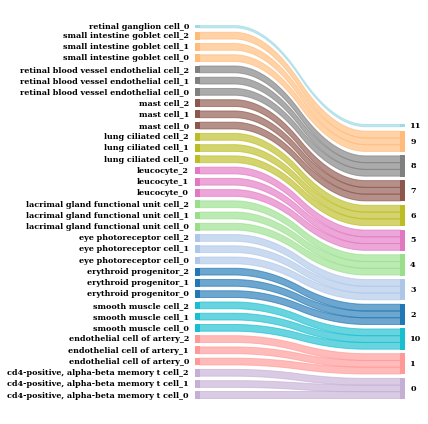

coexpr


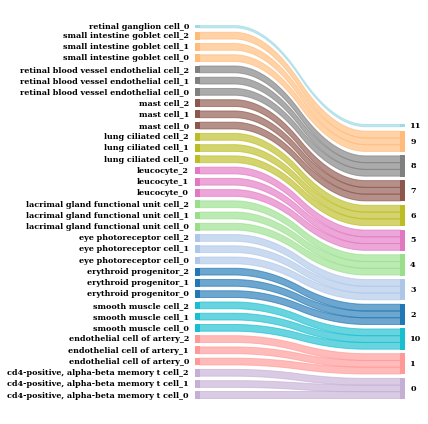

scanpy


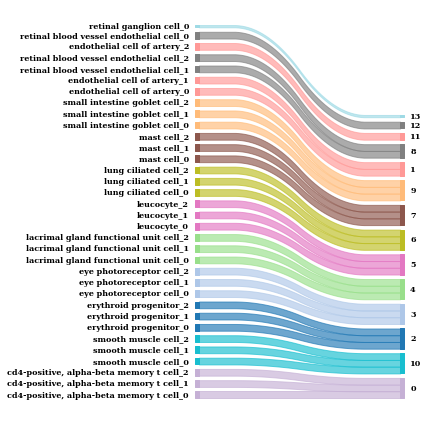

scanpy-neg


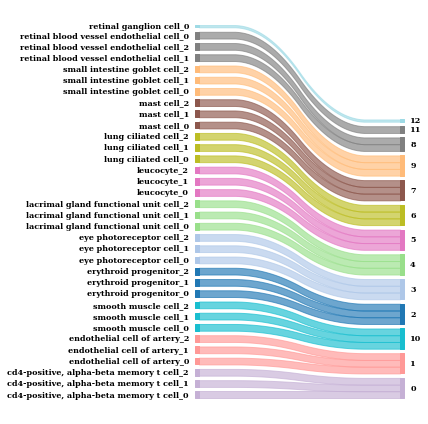

giotto


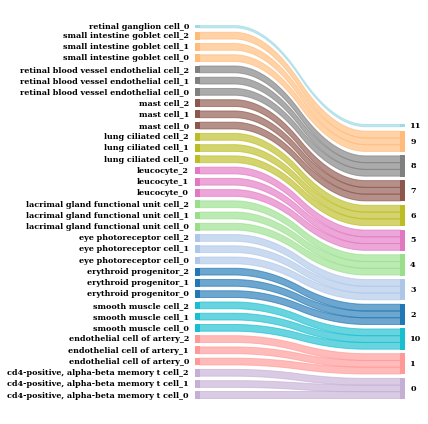

giotto-neg


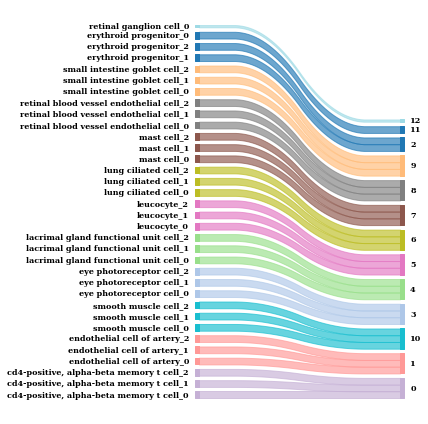

sc-SHC


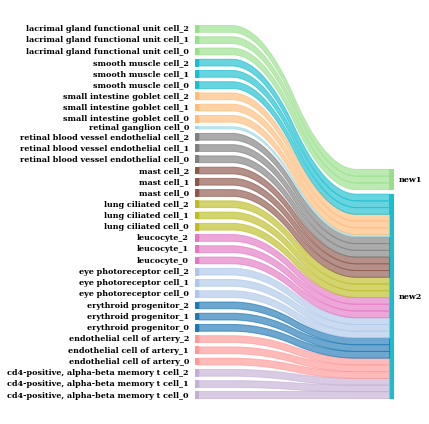

In [114]:
import cytocipher.plotting.cluster_diagnostics as cd
imp.reload(cd)
imp.reload(cc.pl)

color_list = tiny.uns[f'overclusters_colors']
cats = list( tiny.obs[f'overclusters'].cat.categories )
color_dict = {cats[i]: color_list[i] for i in range(len(cats))}

for method in methods:
    print(method)
    # Making sure the colors align
    cat = list( tiny.obs[f'overclusters_{method}_merged'].cat.categories )
    merged_labels = tiny.obs[f'overclusters_{method}_merged'].values
    orig_labels = tiny.obs['overclusters'].values
    clust_map = {clust: np.random.choice(orig_labels[merged_labels==clust]) for clust in cat}
    colors = [color_dict[clust_map[clust]] for clust in cat]
    tiny.uns[f'overclusters_{method}_merged_colors'] = colors
    
    cc.pl.merge_sankey(tiny, 'overclusters', f'overclusters_{method}_merged')
    plt.rc('font', family='sans-serif') # Switch back to default font
    plt.show()

In [71]:
method_colors['sc-SHC'] = 'darkorchid'
method_names = ['code', 'coexpr', 'Scanpy', 'Giotto', 'sc-SHC']

In [74]:
method_colors

{'code': 'cyan',
 'coexpr': 'dodgerblue',
 'giotto': 'magenta',
 'giotto-neg': 'orchid',
 'scanpy': 'gold',
 'scanpy-neg': 'goldenrod',
 'sc-SHC': 'darkorchid'}

In [76]:
methods = ['code', 'coexpr', 'scanpy', 'giotto', 'sc-SHC']

In [80]:
times_dict

{'code': 0.04974526564280192,
 'coexpr': 0.048776714007059734,
 'scanpy': 0.05439626375834147,
 'giotto': 0.11599586804707845,
 'sc-SHC': 2.98}

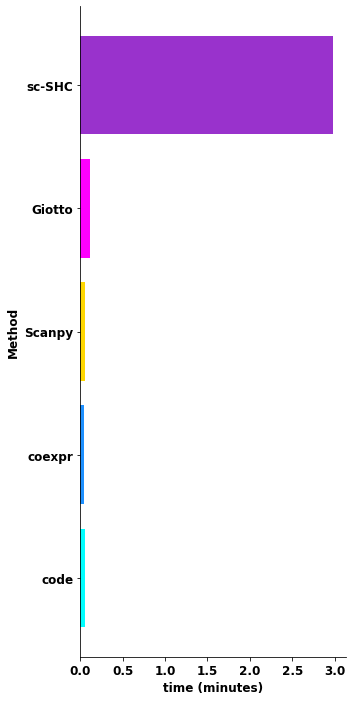

In [79]:
#### Now showing the run times...
times = np.array(list(times_dict.values()))

fig, ax = plt.subplots(figsize=(5,10))
qpl.bar_plot(np.array(methods), np.array(methods), times, 
             colors=np.array([method_colors[method] for method in methods]),
             fig=fig, ax=ax, show=False, label_size=0, rank=False, tick_size=12,
            horizontal=True)
ax.set_xlabel('time (minutes)')
ax.set_yticks(list(range(len(method_names))))
ax.set_yticklabels(method_names)
ax.set_ylabel('Method')
plt.show()

In [81]:
times_dict

{'code': 0.04974526564280192,
 'coexpr': 0.048776714007059734,
 'scanpy': 0.05439626375834147,
 'giotto': 0.11599586804707845,
 'sc-SHC': 2.98}

In [82]:
np.array(list(times_dict.values()))*60 # seconds

array([  2.98471594,   2.92660284,   3.26377583,   6.95975208,
       178.8       ])